In [36]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from datetime import datetime
from Data import Data

import itertools
from collections import Counter
import pickle

In [37]:
def deseasonalize_avg_std(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    Avgs = np.zeros((n,freq))
    Stds = np.zeros((n,freq))
    for i in range(n):
        temp = np.copy(data[:,i])
        temp = np.ravel(temp)
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
            Avgs[i,j] = temp[Idx].mean()
            Stds[i,j] = temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)       
    return(data_deseasonal, Avgs, Stds)

def southern_season(data,s_index,n=6):
    data = pd.DataFrame(data)
    n_index = ~s_index
    data_south = pd.concat([data.iloc[s_index,n:].transpose(),data.iloc[s_index,:n].transpose()],ignore_index=True,sort=False, axis=0)
    data_north = data.iloc[n_index,:]
    data_south = data_south.transpose()
    d = pd.concat([data_north,data_south],ignore_index=False,sort=False, axis=1)
    d.iloc[s_index,:n*2] = d.iloc[s_index,n*2:]
    d.columns = list(np.arange(n*4))
    d = d.drop(d.columns[list(np.arange(n*2,n*4))], axis = 1)
    return(d)

def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

def koppen_finder(data):

    pre = data[:12]
    air = data[12:]
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14

    if MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                return('BWh')
            else:
                return('BWk')
        else:
            if MAT >= 18:
                return('BSh')
            else:
                return('BSk')
        
    elif Tcold >= 18:
        if Pdry >= 60:
            return('Af')
        elif Pdry >= (100 - (MAP/25)):
            return('Am')
        else:
            return('Aw')
        
    elif Thot < 10:
        if Thot > 0:
            return('ET')
        else:
            return('EF')
      
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Cs{}'.format(Ctype(Thot, Tmon10)))          
        elif Pwdry < Pswet/10:
            return('Cw{}'.format(Ctype(Thot, Tmon10)))  
        else:
            return('Cf{}'.format(Ctype(Thot, Tmon10))) 
        
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))           
        elif Pwdry < Pswet/10:
            return('Dw{}'.format(Dtype(Thot, Tmon10, Tcold))) 
        else:
            return('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))

    else:
        return('NAN')

In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [5]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}


temporal_limits = {"time_min":datetime(start_year[0], 1, 16, 0, 0),"time_max":datetime(end_year[0], 12, 16, 0, 0)}
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lons = d.get_lon()
lats = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [73]:
end_year

array([1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980,
       1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])

In [26]:
I = np.where(~pd.isna(df.clusters.values))[0]

In [6]:
I = np.load("af_index.npy")
df_af = df.iloc[I,:]

In [7]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [24]:
koppen = np.load("africa_koppen_1900_2020.npy")

In [10]:
df_centroid = pd.read_csv("centroids_kottek.csv")

In [11]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}

dist= []

In [ ]:
for class_name in df_centroid.columns:
    class_data = df_centroid[class_name].values
    class_m = np.ones(data.T.shape)*class_data.reshape(-1,1)
    dist.append(np.sqrt(((class_m-np.array(data).T) ** 2).sum(0)))

In [13]:
df_centroid = pd.read_csv("centroids_clustering_1951_2000_af_norm.csv")

In [12]:
class_names = df_centroid.columns
dist = np.load("./dist_1951_2000/{}.npy".format('Af'))
data = np.zeros((dist.shape[0], dist.shape[1], len(class_names)))

In [14]:
for i in range(len(class_names)):
    dist = np.load("./dist_1951_2000/{}.npy".format(class_names[i]))
    data[:,:,i] = dist

In [15]:
results = []
for i in range(dist.shape[0]):
    result = []
    for j in range(dist.shape[1]):
        result.append(class_names[np.argmin(data[i,j,:])])
    results.append(result)

results = np.array(results)

In [25]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [7]:
koppen = np.load("africa_koppen_{}_{}.npy".format(start,end))

In [8]:
df_centroid = pd.read_csv("centroids_clustering_{}_{}_af.csv".format(start,end))

In [223]:
dist = np.load("./dist_{}_{}/{}.npy".format(start, end,'Aw'))

In [225]:
start = 1951
end = 2000

In [226]:
df_centroid = pd.read_csv("centroids_clustering_{}_{}_af_norm.csv".format(start,end))

In [227]:
class_list = np.load("koppen_{}_{}.npy".format(start,end))
df["clusters"] = class_list

I = np.load("af_index.npy")
df_af = df.loc[I,:]
class_list = class_list[I]
df["velocity"] = 0

In [228]:
for class_name in df_centroid.columns:
    dist = np.load("./dist_{}_{}/{}.npy".format(start, end,class_name))
    index = (class_list == class_name)
    velocity = (dist[0,:] - dist[-1,:])/90
    df_af.iloc[index,3] = np.reshape(velocity[index],(-1,1))

In [229]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values
           # if df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

In [230]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


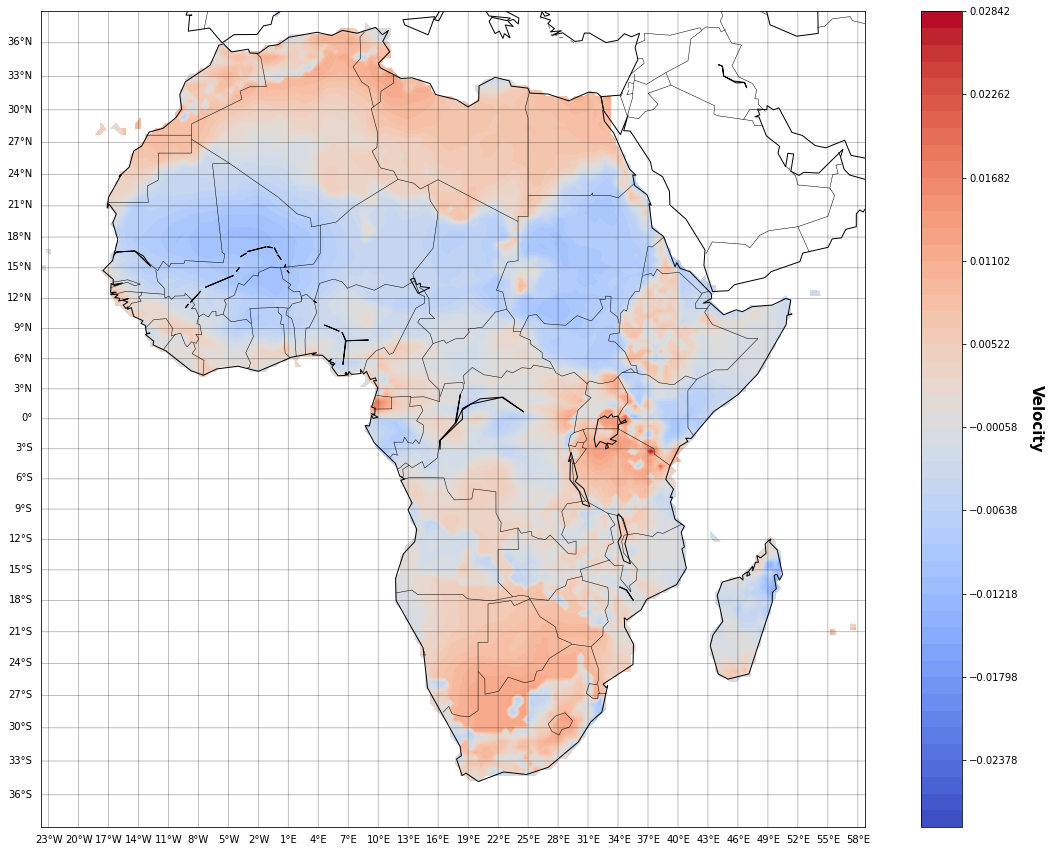

In [233]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
cbar = plt.colorbar();
cbar.set_label('Velocity', rotation=270,labelpad=25, size=15,weight='bold')
#plt.title(' EOF {}'.format(pc), fontsize = 20)
plt.savefig("Velocity_Subtypes_{}_{}.png".format(start, end))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


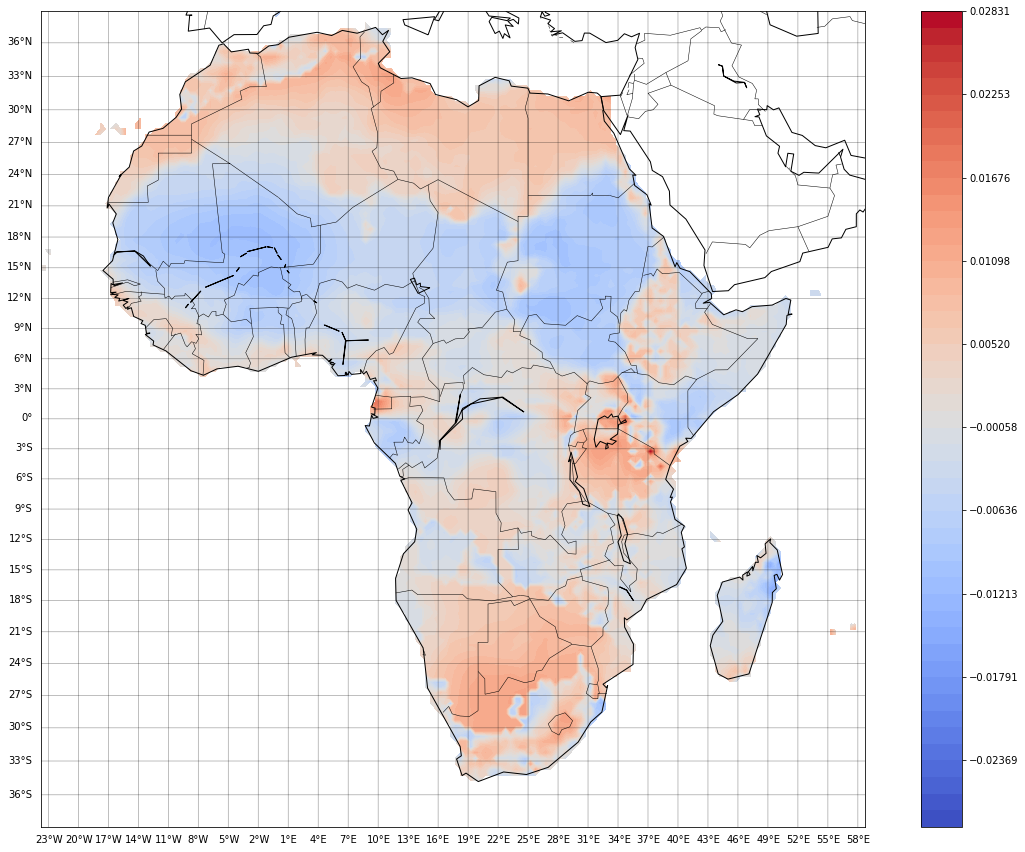

In [35]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

# Major Classes

In [210]:
start = 1901
end = 2020

df_centroid = pd.read_csv("centroids_majors_{}_{}_af_norm.csv".format(start,end))

In [135]:
#class list from KGC from start to end
class_list = np.load("koppen_{}_{}.npy".format(start,end))

class_major = []
for i in range(len(class_list)):
    class_major.append(class_list[i][0])
class_list = np.array(class_major)

df["clusters"] = class_list

I = np.load("af_index.npy")
df_af = df.loc[I,:]
class_list = class_list[I]
df["velocity"] = 0

In [211]:
#class list from clustering of 1901 to 1930
dist = np.zeros((10662,3))
df_dist = pd.DataFrame(dist,columns=['A', 'B', 'C'])
df_dist['A'] = np.load("./dist_majors_{}_{}/A.npy".format(start, end,class_name))[0,:]
df_dist['B'] = np.load("./dist_majors_{}_{}/B.npy".format(start, end,class_name))[0,:]
df_dist['C'] = np.load("./dist_majors_{}_{}/C.npy".format(start, end,class_name))[0,:]
min_index = np.argmin(np.array(df_dist), axis=1)
class_list = df_dist.columns[min_index].values

I = np.load("af_index.npy")
df["velocity"] = 0
df_af = df.loc[I,:]
df_af["clusters"] = class_list

In [206]:
#for Vilocity only
for class_name in df_centroid.columns:
    dist = np.load("./dist_majors_{}_{}/{}.npy".format(start, end,class_name))
    index = (class_list == class_name)
    velocity = (dist[-1,:] - dist[0,:])/90
    df_af.iloc[index,3] = np.reshape(velocity[index],(-1,1))

In [212]:
#for Vilocity and Acc
for class_name in df_centroid.columns:
    dist = np.load("./dist_majors_{}_{}/{}.npy".format(start, end,class_name))
    index = (class_list == class_name)
    velocity = (dist[0,:] - dist[-1,:])/90
    sign = np.sign(velocity)
    velocity1 = (dist[0,:] - dist[10,:])/50
    velocity2 = (dist[10,:] - dist[-1,:])/40    
    velocity = (velocity2/velocity1) * sign
    df_af.iloc[index,3] = np.reshape(velocity[index],(-1,1))

In [213]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values
           # if df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

In [214]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

In [215]:
vmin = -15
vmax = 15

In [216]:
deg [ deg >= vmax] = vmax
deg [ deg <= vmin] = vmin

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


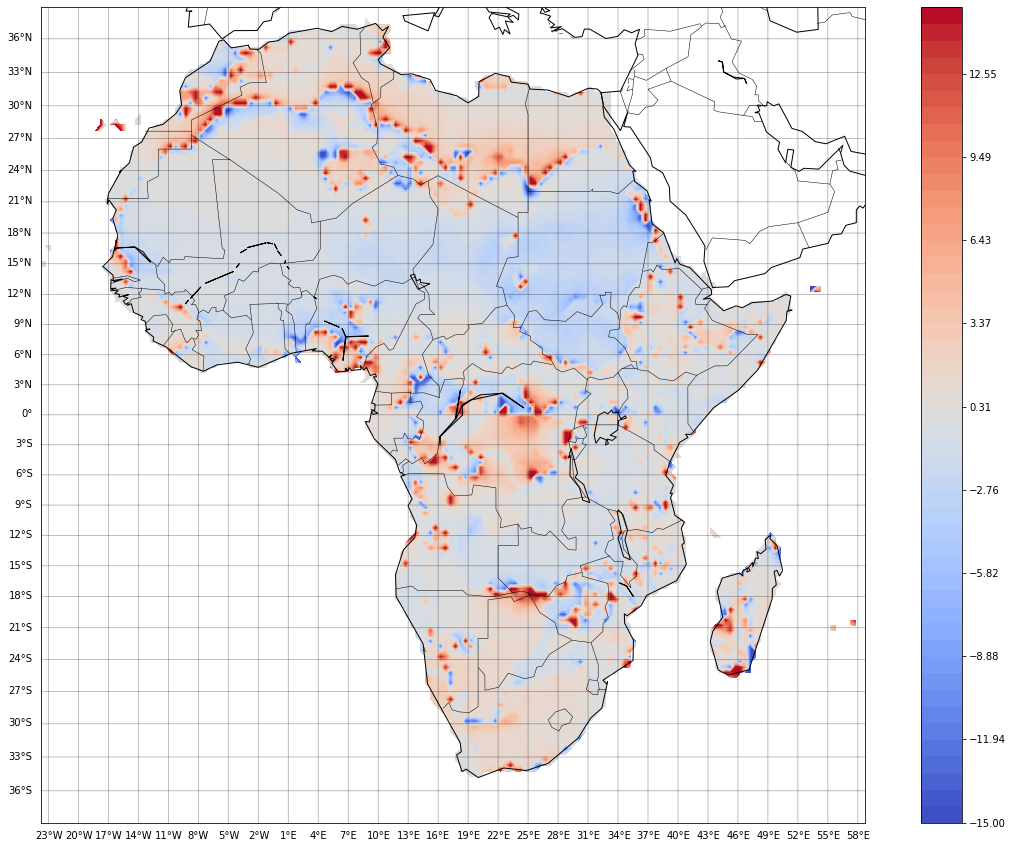

In [220]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


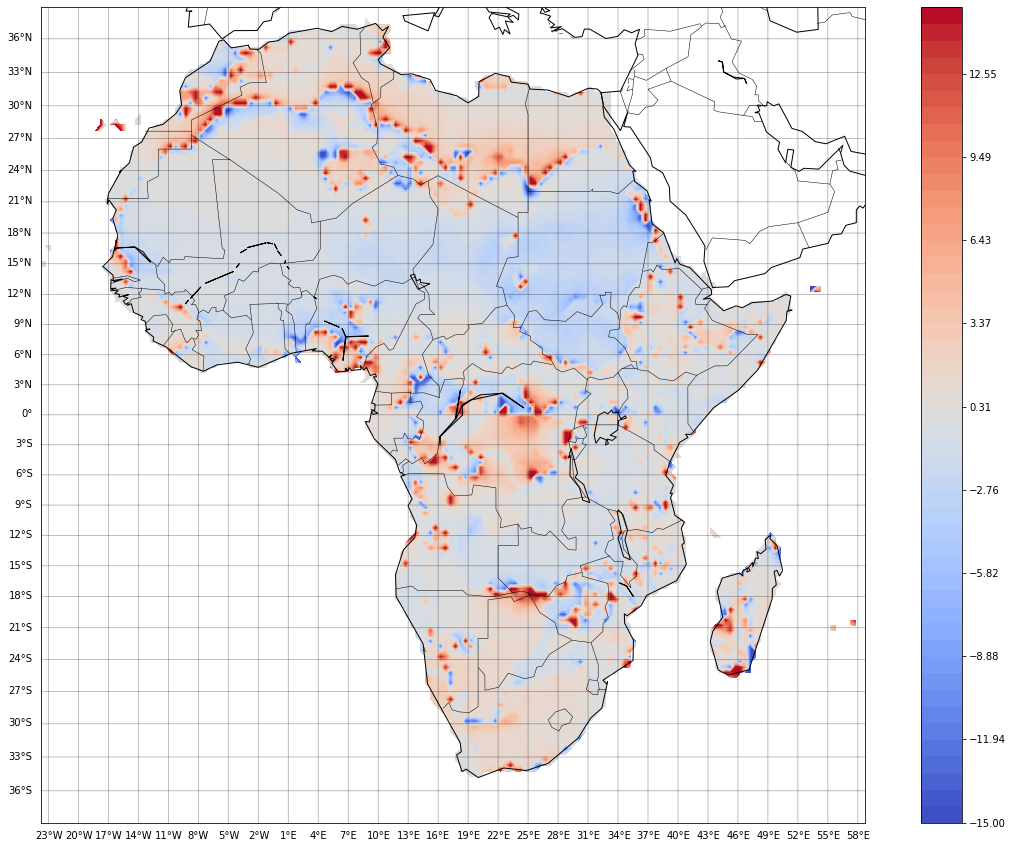

In [217]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


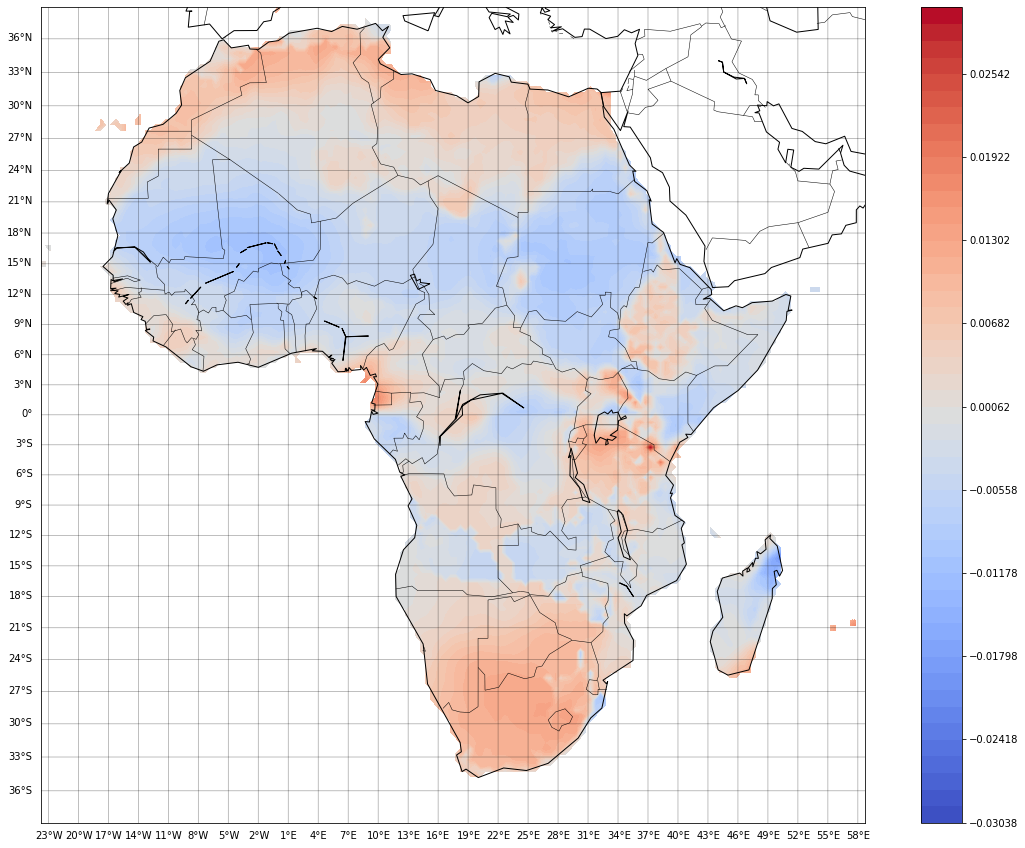

In [133]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


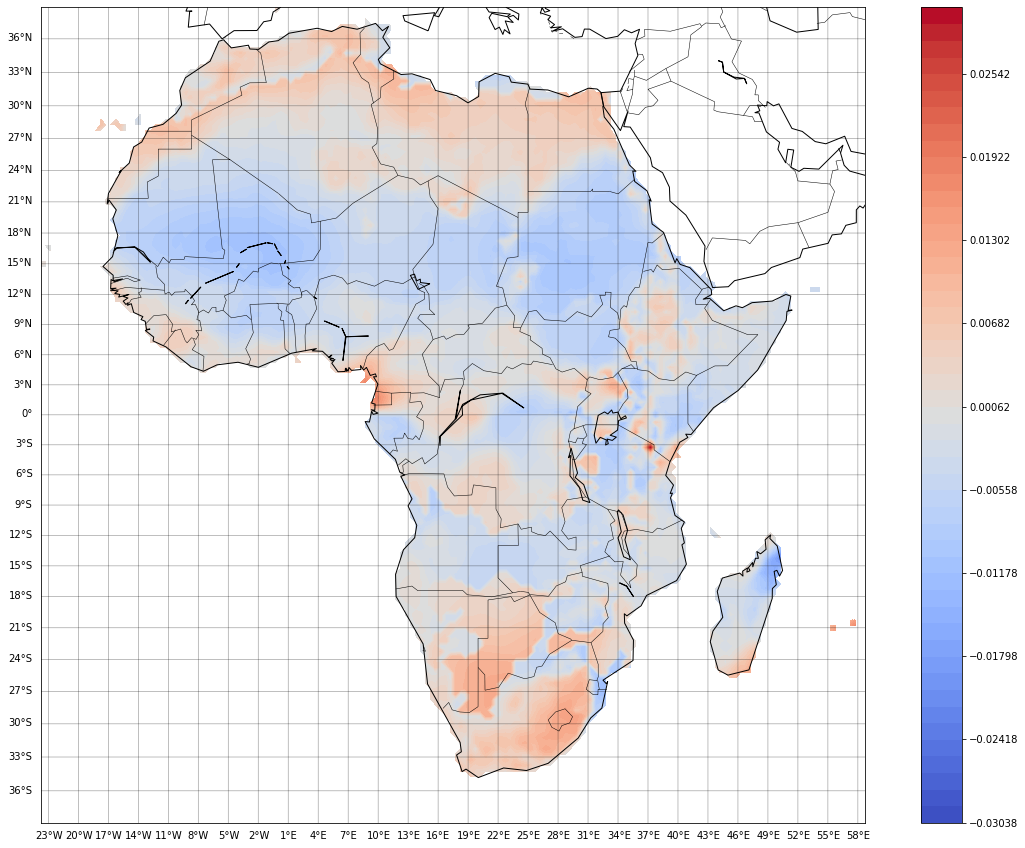

In [209]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

# Specific Class

In [16]:
class_name = "Aw"
#dist = np.load("dist_{}.npy".format(class_name))
dist = np.load("./dist_1901_2020/{}.npy".format(class_name))

class_list = np.load("koppen_1901.2020.npy")
df["clusters"] = class_list


velocity = (dist[0,:] - dist[-1,:])/90
df_af["velocity"] = velocity

class_list = class_list[I]
index = (class_list == class_name)
df_af.iloc[index,3] = np.nan

In [17]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].velocity.values
           # if df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

In [18]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


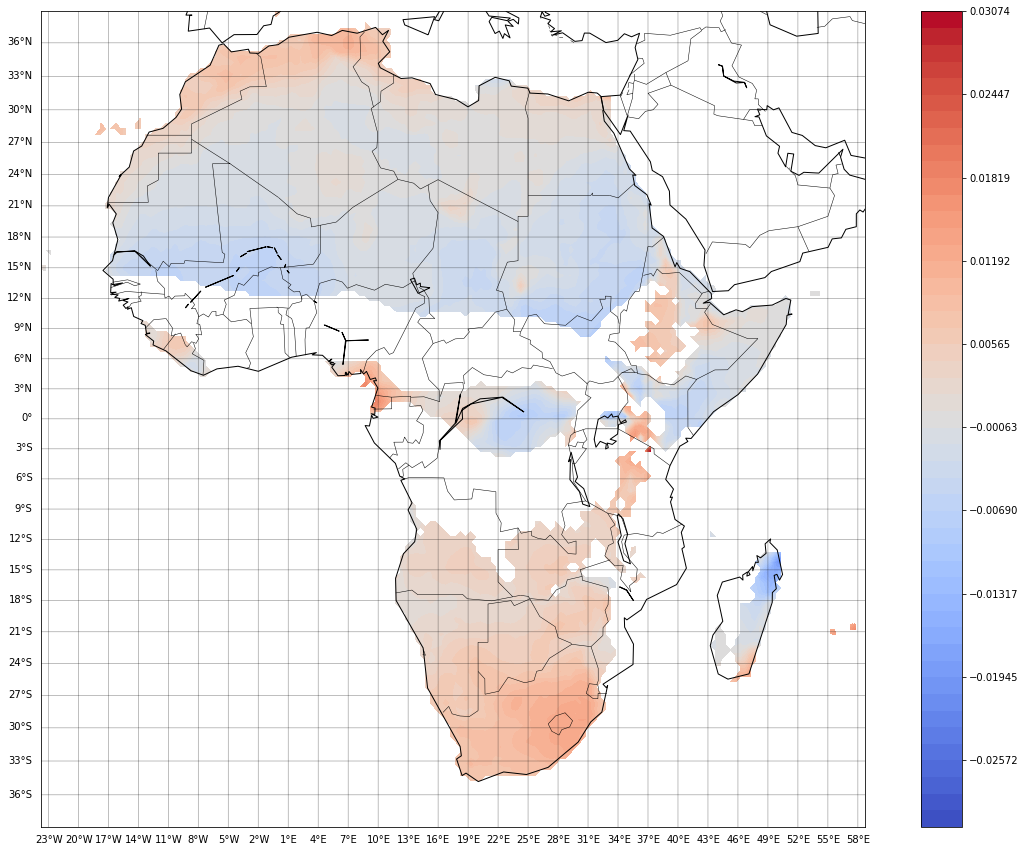

In [19]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [ ]:
velocity = (dist[0,:] - dist[-1,:])/90

df["velocity"] = velocity

index = (class_list == class_name)

df.iloc[~index,2] = np.nan

deg = np.zeros((len(lat),len(lon)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon[j])].velocity.values
           # if df[(df.lats == lat[i]) & (df.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

# Major Classses

In [120]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [121]:
class_major = []
for i in range(len(class_list)):
    class_major.append(class_list[i][0])
class_major = np.array(class_major)    

In [122]:
class_name = "C"

dist = np.load("./dist_major/dist_{}.npy".format(class_name))

index = (class_major == class_name)

In [123]:
velocity = (dist[0,:] - dist[-1,:])/90
df["velocity"] = velocity

index = (class_major == class_name)
df.iloc[~index,2] = np.nan

deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values
        else:
            deg[i,j]=np.nan

In [124]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


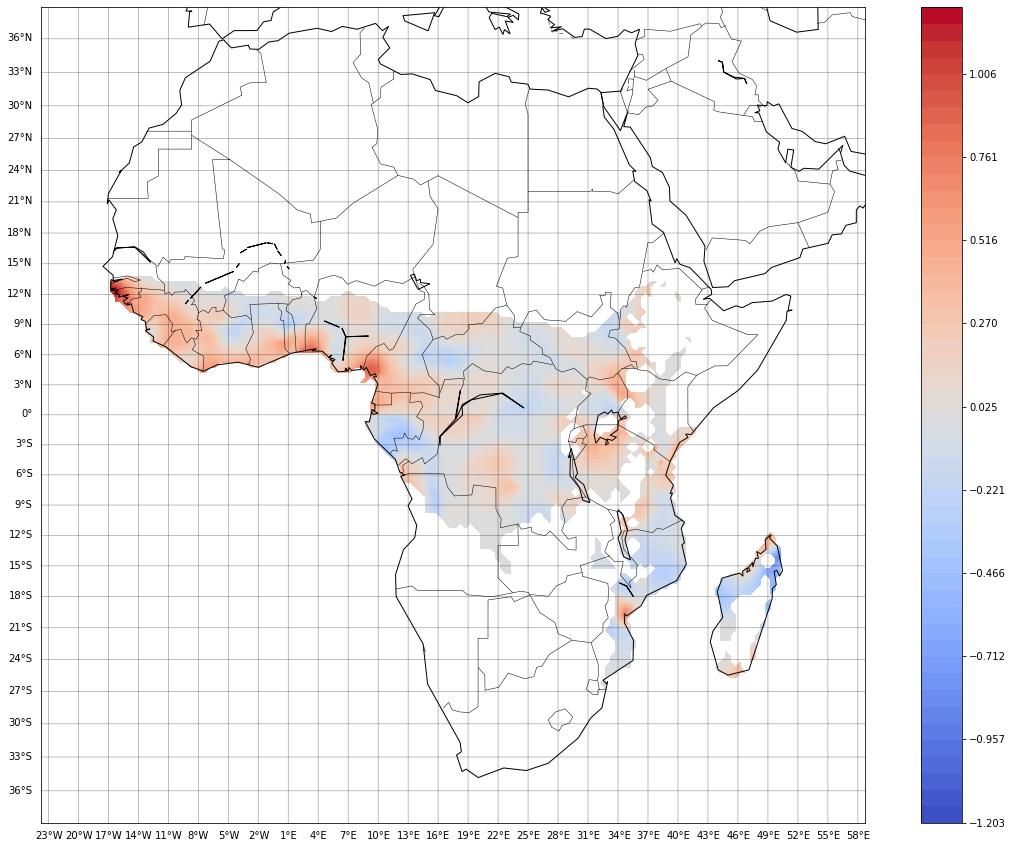

In [110]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


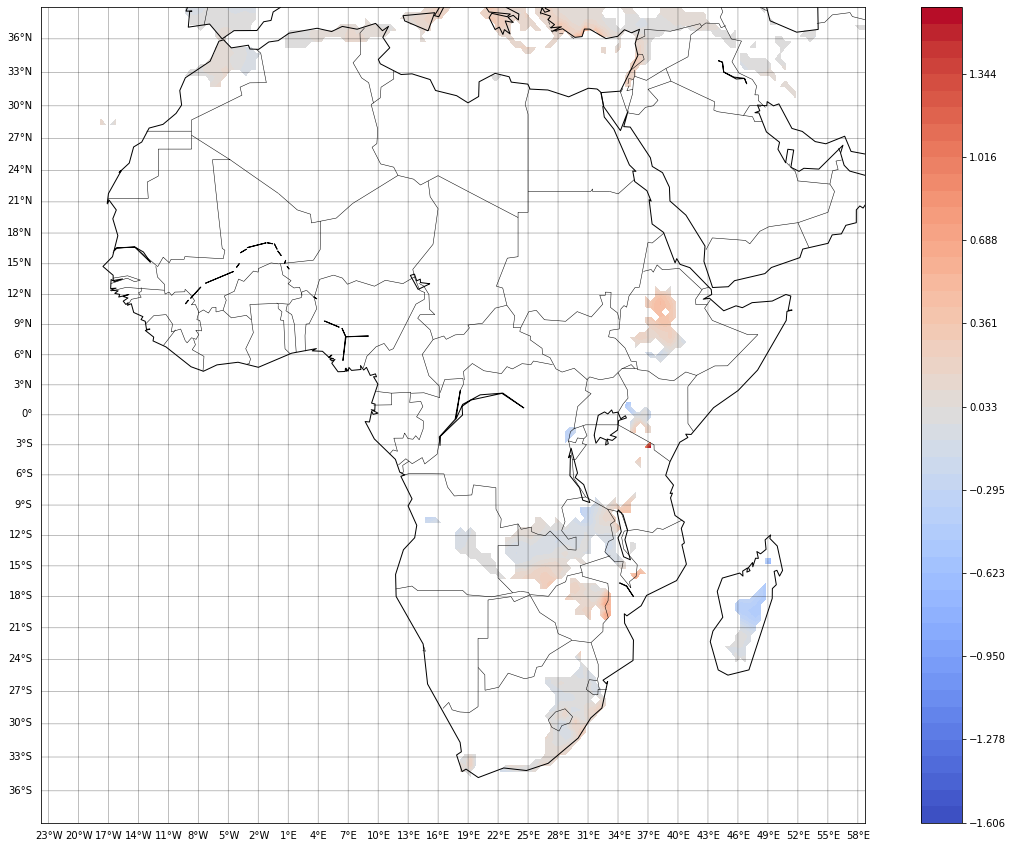

In [125]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [126]:
velocity = (dist[0,:] - dist[-1,:])/90
df["velocity"] = velocity

index = (class_major == class_name)
df.iloc[index,2] = np.nan

In [127]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values
        else:
            deg[i,j]=np.nan

if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


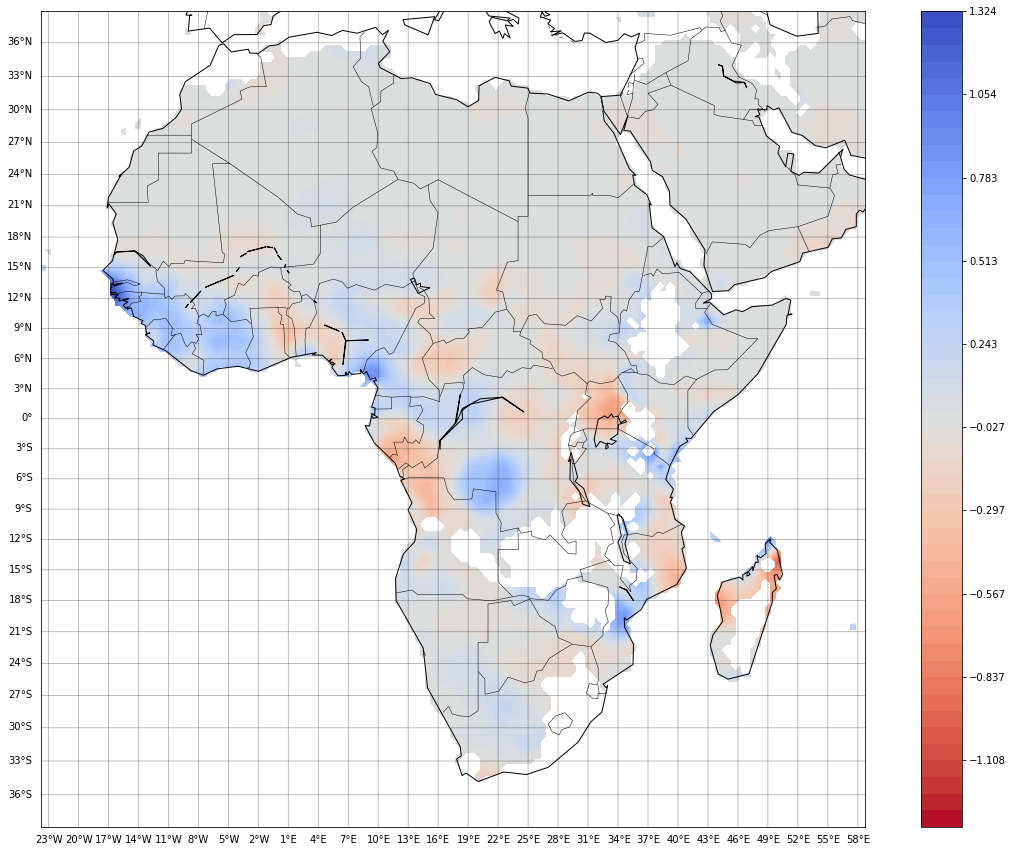

In [128]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm_r'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [11]:
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

In [12]:
d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp', missing_value=9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

index = np.where(result_air[0,:] != 9.96921e+36)[1]

result_air = result_air[:,index]
lon_list_air = np.array(lon_list_air)[index]
lat_list_air = np.array(lat_list_air)[index]

In [15]:
precipitation = result.copy()
temperature = result_air.copy()


precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
temperature, avgs_temp, stds_temp = deseasonalize_avg_std(temperature)

In [16]:
avgs_pre = pd.DataFrame(avgs_pre)
avgs_air = pd.DataFrame(avgs_temp)

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

s_index = (df["lats"] <= 0).values
n_index = (df["lats"] > 0).values

avgs_pre = southern_season(avgs_pre,s_index)
avgs_air = southern_season(avgs_temp,s_index)

#data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [17]:
avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [18]:
avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [19]:
data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [20]:
data = data.transpose()

In [21]:
data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,286.140839,177.799164,136.073334,99.060013,103.612503,145.448334,174.935837,258.080017,282.253326,305.632477,...,25.318335,24.664167,24.334167,24.895834,25.299999,26.201666,26.873331,27.076666,27.421667,26.945833
1,47.700832,45.965828,31.770000,34.014168,25.574165,25.651669,20.490000,17.215000,22.113335,43.599171,...,-18.485832,-20.221668,-20.713335,-19.028332,-12.740001,-3.156667,4.807500,9.005000,8.115833,3.479167
2,45.274170,45.288334,29.486666,31.868334,24.909168,24.085001,19.600000,16.580833,21.305836,42.912498,...,-19.184166,-21.021667,-21.506666,-19.830000,-13.550000,-3.660833,4.405000,8.501666,7.518333,2.978333
3,36.838333,42.014999,26.743336,29.362499,22.541666,23.468332,16.918333,15.996668,23.305000,45.211670,...,-20.575834,-22.316668,-23.014168,-21.732502,-15.560834,-5.465834,2.806667,6.807500,5.820000,1.486667
4,34.847500,41.191666,24.701666,27.549166,21.036665,21.580000,15.932500,15.407499,22.744167,44.294170,...,-21.268335,-23.100834,-23.918335,-22.533333,-16.462500,-6.057500,2.310833,6.113333,5.221666,0.882500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67415,34.700001,35.410835,20.489166,23.795834,16.911669,17.013334,19.075001,23.718332,29.063334,49.105000,...,-25.748331,-27.825832,-28.846666,-27.220833,-20.084167,-9.244167,-0.797500,2.842500,1.742500,-2.298333
67416,33.189999,34.349171,18.290833,22.616669,15.119166,16.019165,17.339169,22.070833,27.254168,47.023331,...,-26.125834,-28.385000,-29.344999,-27.621666,-20.474165,-9.537500,-0.984167,2.460833,1.445833,-2.590000
67417,32.669998,32.962502,17.564167,21.383333,14.087500,14.009166,14.585834,17.292501,22.490002,40.873333,...,-25.014166,-27.223331,-28.049166,-26.209167,-19.176668,-8.120833,0.633333,3.872500,2.759166,-1.180000
67418,6.982500,11.329166,19.576668,18.008333,12.110834,6.168334,5.429167,2.858333,12.128333,33.441666,...,-25.213335,-26.096668,-27.351667,-25.821667,-18.360003,-6.327500,3.785833,8.117499,6.590001,0.948333


In [27]:
climate = []
for i in range(data.shape[0]):
    pre = data.iloc[i,:12].values
    air = data.iloc[i,12:].values
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14


    if Tcold >= 18:
        if Pdry >= 60:
            climate.append('Af')
            continue
        elif Pdry >= (100 - (MAP/25)):
            climate.append('Am')
            continue
        elif np.argmin(pre) < 6:
            climate.append('Aw')
            continue
        else:
            climate.append('As')
            continue
    elif MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                climate.append('BWh')
                continue
            else:
                climate.append('BWk')
                continue
        else:
            if MAT >= 18:
                climate.append('BSh')
                continue
            else:
                climate.append('BSk')
                continue
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
            continue  
        else:
            climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
            continue  
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
        else:
            climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
    elif Thot < 10:
        if Thot > 0:
            climate.append('ET')
        else:
            climate.append('EF')
    else:
        climate.append('NAN')

In [29]:
len(climate)

67420

In [31]:
df['class'] = climate

In [32]:
df

,lons,lats,class
0,-179.75,-16.25,Af
1,-179.75,65.25,ET
2,-179.75,65.75,ET
3,-179.75,66.25,ET
4,-179.75,66.75,ET
...,...,...,...
67415,179.75,67.75,ET
67416,179.75,68.25,ET
67417,179.75,68.75,ET
67418,179.75,70.75,ET


In [51]:
with open('koppen_class.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
dic = {}
for i in range(df.shape[0]):
    dic[(df.iloc[i,1],df.iloc[i,0])] = df.iloc[i,2]

In [50]:
dic[(68.25, -179.25)]

'ET'

In [47]:
class_dic

{(-89.75, -179.75): 'EF',
 (-89.75, -179.25): 'EF',
 (-89.75, -178.75): 'EF',
 (-89.75, -178.25): 'EF',
 (-89.75, -177.75): 'EF',
 (-89.75, -177.25): 'EF',
 (-89.75, -176.75): 'EF',
 (-89.75, -176.25): 'EF',
 (-89.75, -175.75): 'EF',
 (-89.75, -175.25): 'EF',
 (-89.75, -174.75): 'EF',
 (-89.75, -174.25): 'EF',
 (-89.75, -173.75): 'EF',
 (-89.75, -173.25): 'EF',
 (-89.75, -172.75): 'EF',
 (-89.75, -172.25): 'EF',
 (-89.75, -171.75): 'EF',
 (-89.75, -171.25): 'EF',
 (-89.75, -170.75): 'EF',
 (-89.75, -170.25): 'EF',
 (-89.75, -169.75): 'EF',
 (-89.75, -169.25): 'EF',
 (-89.75, -168.75): 'EF',
 (-89.75, -168.25): 'EF',
 (-89.75, -167.75): 'EF',
 (-89.75, -167.25): 'EF',
 (-89.75, -166.75): 'EF',
 (-89.75, -166.25): 'EF',
 (-89.75, -165.75): 'EF',
 (-89.75, -165.25): 'EF',
 (-89.75, -164.75): 'EF',
 (-89.75, -164.25): 'EF',
 (-89.75, -163.75): 'EF',
 (-89.75, -163.25): 'EF',
 (-89.75, -162.75): 'EF',
 (-89.75, -162.25): 'EF',
 (-89.75, -161.75): 'EF',
 (-89.75, -161.25): 'EF',
 (-89.75, -1

In [53]:
pre = data.iloc[0,:12].values
air = data.iloc[0,12:].values

In [57]:
pre

array([174.93583679, 258.08001709, 282.25332642, 305.63247681,
       285.85998535, 314.10250854, 286.14083862, 177.79916382,
       136.07333374,  99.06001282, 103.61250305, 145.44833374])

In [60]:
pre[:6].sum()

1620.8641510009766

12

In [74]:
climate = []

MAP = pre.sum()
Pdry = pre.min()
Pwinter = pre[:6].sum()
Psummer = pre[6:].sum()
Pwdry = Pwinter.min()
Psdry = Psummer.min()
Pwwet = Pwinter.max()
Pswet = Psummer.max()


MAT = air.mean()
Tcold = air.min()
Thot = air.max()
Tmon10 = np.count_nonzero(air > 10)

if Pwinter >= 0.7 * MAP:
    Pthresh = 2 * MAT
elif Psummer >= 0.7 * MAP:
    Pthresh = 2 * MAT + 28 
else:
    Pthresh = 2 * MAT + 14


if Tcold >= 18:
    if Pdry >= 60:
        climate.append('Af')
        continue
    elif Pdry >= (100 - (MAP/25)):
        climate.append('Am')
        continue
    elif np.argmin(pre) < 6:
        climate.append('Aw')
        continue
    else:
        climate.append('As')
        continue
elif MAP < 10 * Pthresh:
    if MAP < 5 * Pthresh:
        if MAT >= 18:
            climate.append('BWh')
            continue
        else:
            climate.append('BWk')
            continue
    else:
        if MAT >= 18:
            climate.append('BSh')
            continue
        else:
            climate.append('BSk')
            continue
elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
        continue  
    else:
        climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
        continue  
elif (Thot > 10) and (Tcold <=0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
    else:
        climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
elif Thot < 10:
    if Thot > 0:
        climate.append('ET')
    else:
        climate.append('EF')

SyntaxError: 'continue' not properly in loop (<ipython-input-74-0d50a2996bbf>, line 29)

In [72]:
def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

In [73]:
def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

In [66]:
if Thot >= 22:
    climate.append('Csa')
    continue            
elif Tmon10 >= 4:
    climate.append('Csb')
    continue 
elif (Tmon10 >= 1) and (Tmon10 < 4):
    climate.append('Csc')
    continue 

In [67]:
a < b/3

True